In [5]:
import pandas as pd
import matplotlib.pyplot as plt

In [93]:
def draw_macc(industry_sector_macc, ACC_load_shape_results, sector_to_plot, acc_sector):
    """
    Draws a MACC for a given sector and ACC sector.

    Args:
        industry_sector_macc (pd.DataFrame): The industry sector MACC data
        ACC_load_shape_results (pd.DataFrame): The ACC load shape results
        sector_to_plot (str): The sector to plot
        acc_sector (str): The ACC sector

    Returns:
        None, plots MACC
    """
    fig, ax = plt.subplots(figsize=(15, 7))
    sector_data = industry_sector_macc[industry_sector_macc['Sector'] == sector_to_plot]
    grid_data = sector_data[sector_data['Lever'] == 'Grid decarbonization']
    non_grid_data = sector_data[sector_data['Lever'] != 'Grid decarbonization'].sort_values('Abatement Cost Mid ($/t CO2)')
    sector_acc_data = ACC_load_shape_results.loc[ACC_load_shape_results['baseload_pattern_name'] == acc_sector].sort_values('acc_alpha_t')
    grid_share = grid_data['% Share of Sector Abatement Potential'].values[0]

    grid_segments = []
    for _, acc_row in sector_acc_data.iterrows():
        new_row = grid_data.iloc[0].copy()
        new_row['Abatement Cost Low ($/t CO2)'] = acc_row['acc_alpha_t'] - acc_row['acc_alpha_t']/2
        new_row['Abatement Cost High ($/t CO2)'] = acc_row['acc_alpha_t'] + acc_row['acc_alpha_t']/2
        new_row['Abatement Cost Mid ($/t CO2)'] = acc_row['acc_alpha_t']
        new_row['alpha'] = acc_row['alpha']
        new_row['% Share of Sector Abatement Potential'] = grid_share / len(sector_acc_data)
        grid_segments.append(new_row)
        grid_data = pd.DataFrame(grid_segments)
    
    all_data = pd.concat([non_grid_data, grid_data]) # combine non-grid and grid data
    all_data = all_data.sort_values('Abatement Cost Mid ($/t CO2)') # sort by mid cost
    all_data['Cumulative %'] = all_data['% Share of Sector Abatement Potential'].cumsum() # cumulative percentage
    all_data['Previous Cumulative %'] = all_data['Cumulative %'].shift(1).fillna(0) # previous cumulative percentage
    
    row_color_map = {'Heat': 'red', 'Production': 'blue', 'Electricity': 'yellow', 'Other': 'grey'}
    narrow_bar_positions = [row['Previous Cumulative %'] + row['% Share of Sector Abatement Potential']/2 
                          for _, row in all_data.iterrows() 
                          if row['% Share of Sector Abatement Potential'] < 10 and row['Lever'] != 'Grid decarbonization']
    
    for _, row in all_data.iterrows():
        source = row['Emissions Source'].split('\n')[0]
            
        x_pos = row['Previous Cumulative %'] + row['% Share of Sector Abatement Potential']/2
        label = '\n'.join(row['Lever'].split())
        vertical_offset = 15 * (len(row['Lever'].split()) + 8)
        vertical_offset = 25 if source == 'Heat' else vertical_offset
        
        ax.bar(x_pos, row['Abatement Cost Mid ($/t CO2)'],
               width=row['% Share of Sector Abatement Potential'],
               color=row_color_map[source], alpha=0.2)
        
        # manually adding error bars
        ax.vlines(x_pos, row['Abatement Cost Low ($/t CO2)'],
            row['Abatement Cost High ($/t CO2)'],
            color='black', alpha=0.7)
        ax.hlines([row['Abatement Cost Low ($/t CO2)'],
                    row['Abatement Cost High ($/t CO2)']],
                    x_pos - 2,
                    x_pos + 2,
                    color='black', alpha=0.7)
        if row['Lever'] == 'Grid decarbonization': # add ACC label
            plt.rcParams.update({'mathtext.default': 'regular'})
            ax.text(x_pos, row['Abatement Cost Mid ($/t CO2)'] + 3,
                   f'$ACC_{{{row["alpha"]:.2f}}}$',
                   ha='center', va='center', fontsize=12,
                   color='darkred', weight='bold')
        else: # add error bars
            if row['% Share of Sector Abatement Potential'] < 10:
                # adjusting offset using Claude 3.5 Sonnet
                prev_narrow = [pos for pos in narrow_bar_positions if pos < x_pos]
                x_offset = 5 * len(prev_narrow) if prev_narrow and x_pos - prev_narrow[-1] < 15 else 2
                y_offset = 10 * len(prev_narrow) if prev_narrow and x_pos - prev_narrow[-1] < 15 else 0
                
                ax.annotate(label,
                            xy=(x_pos + 0.5, row['Abatement Cost Mid ($/t CO2)']),
                            xytext=(x_pos + abs(x_offset), row['Abatement Cost High ($/t CO2)'] + vertical_offset + 50 + y_offset),
                            arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=4),
                            ha='center' if x_offset == 0 else 'left',
                            va='center', fontsize=12)
            else:
                ax.text(x_pos, row['Abatement Cost High ($/t CO2)'] + vertical_offset,
                        label, ha='center', va='center', fontsize=12)

    ax.axhline(0, color='black', alpha=0.5)
    ax.set_title(f'{sector_to_plot} MACC', fontsize=16)
    ax.set_xlim(0, 105)
    ax.set_ylim(industry_sector_macc['Abatement Cost Low ($/t CO2)'].min() - 5, industry_sector_macc['Abatement Cost High ($/t CO2)'].max() + 30)
    ax.set_ylabel('Abatement Cost ($/t CO2)', fontsize=14)
    ax.set_xlabel('Cumulative % of Sector Abatement Potential', fontsize=14)
    plt.tight_layout()
    plt.show()

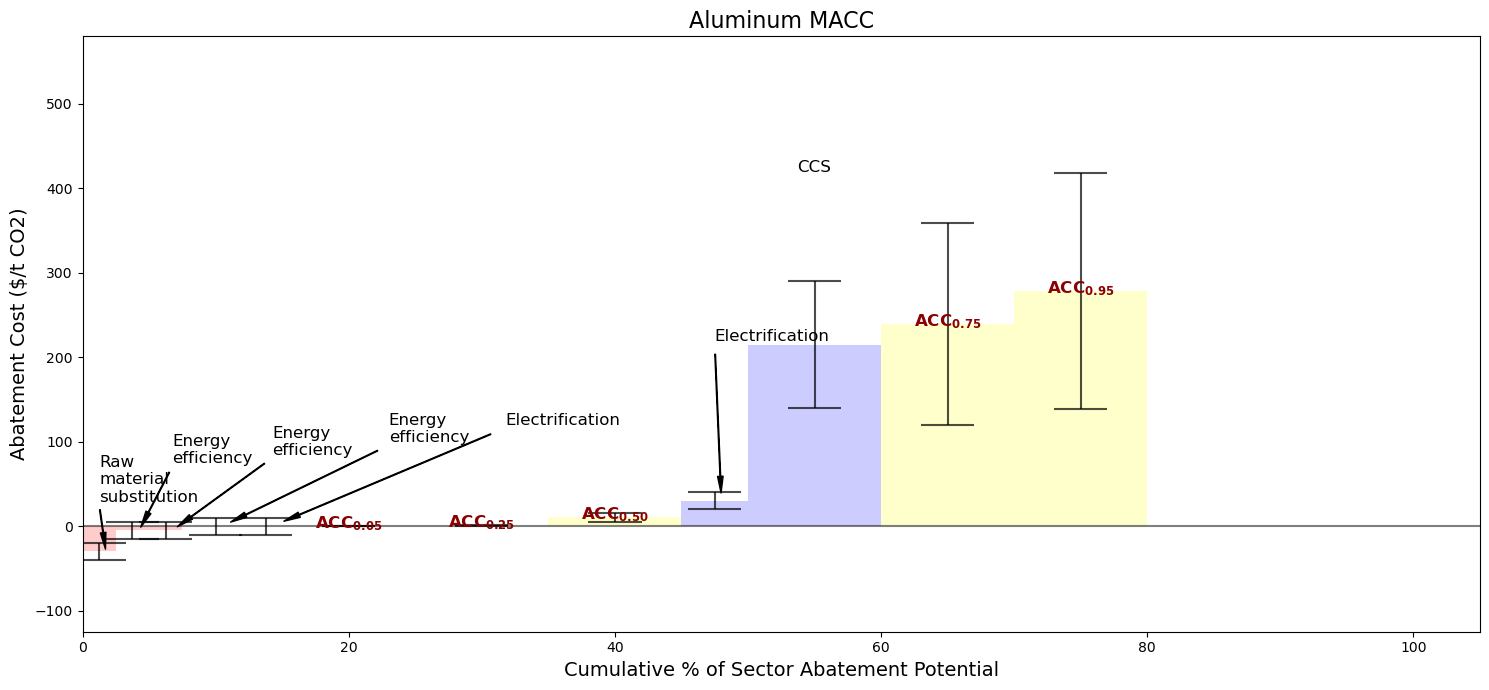

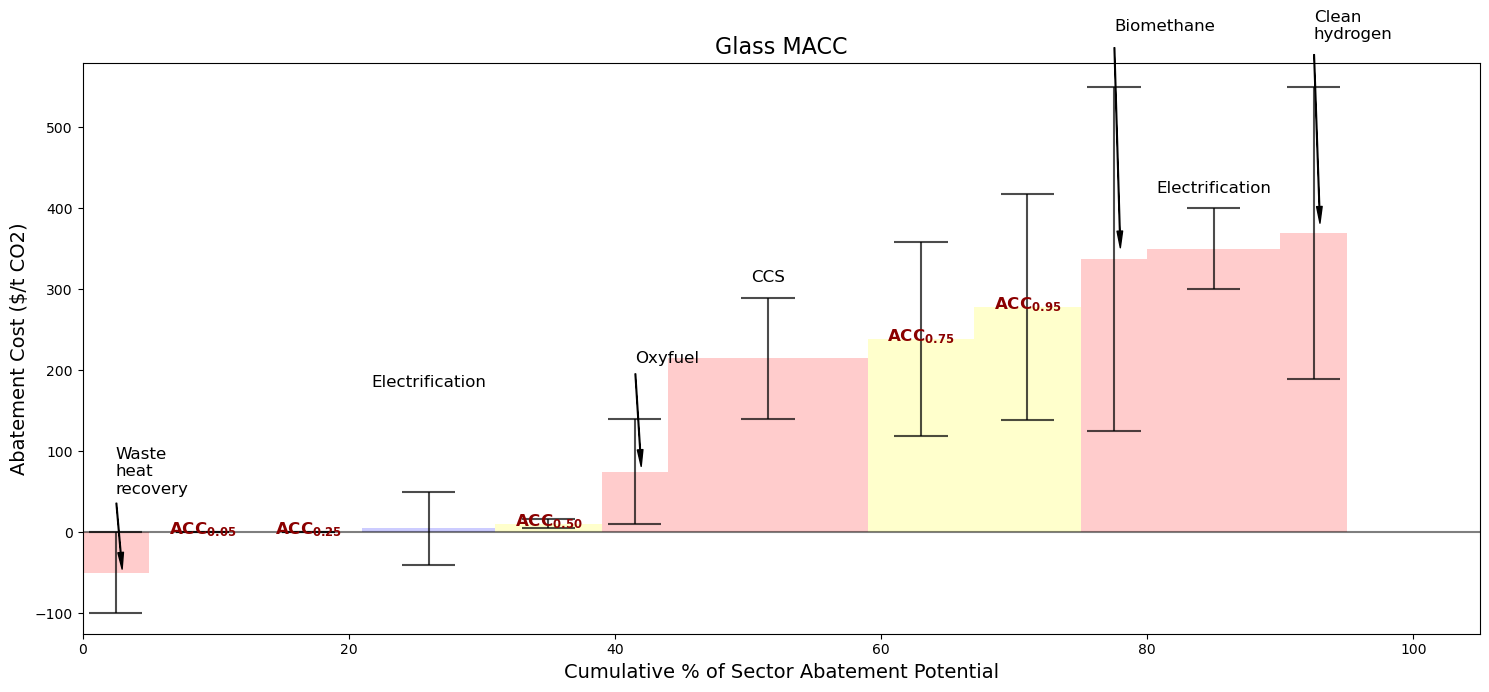

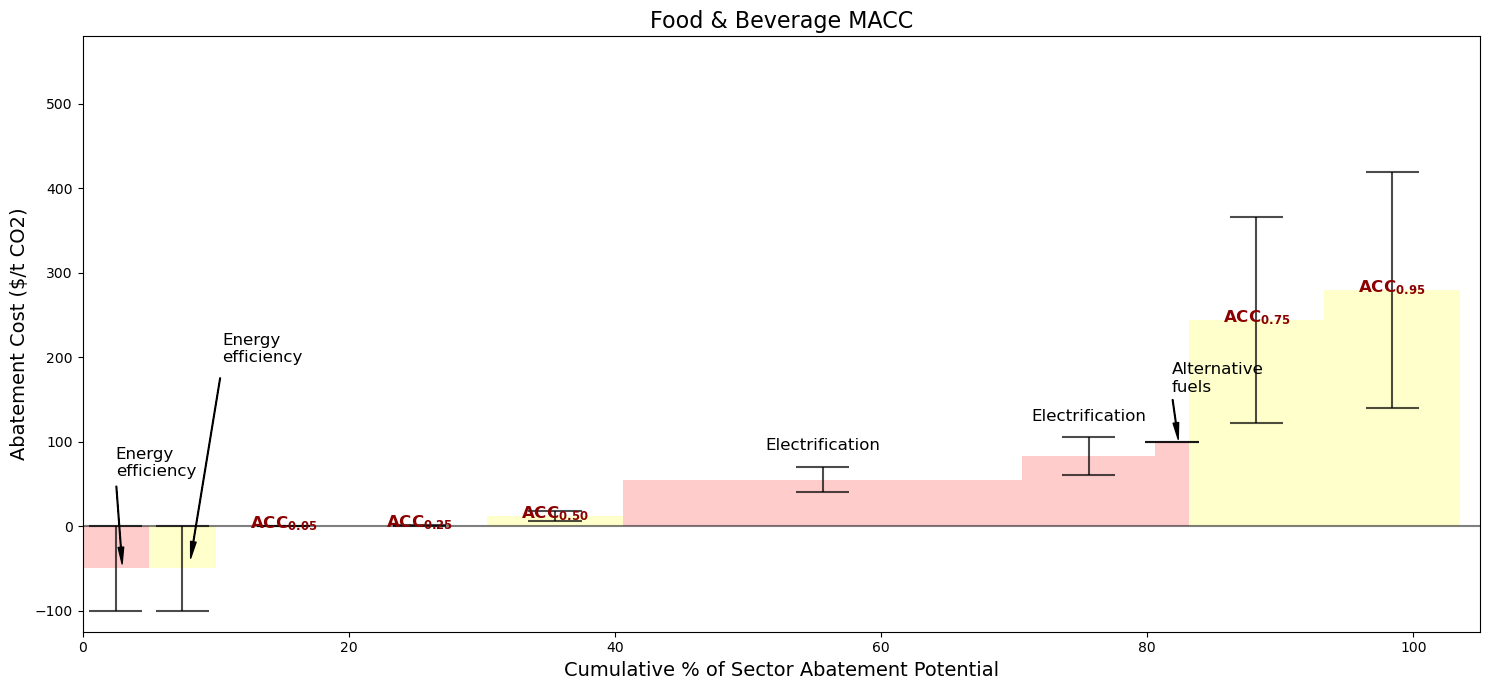

In [94]:

industry_sector_macc = pd.read_csv('../data/macc_comparison/industry_sector_emissions_levers.csv', sep=',')
industry_sector_macc['Emissions Source'] = industry_sector_macc['Emissions Source'].str.replace(r'\s*\(', '\n(', regex=True)
industry_sector_macc['Abatement Cost Mid ($/t CO2)'] = (industry_sector_macc['Abatement Cost Low ($/t CO2)'] + industry_sector_macc['Abatement Cost High ($/t CO2)']) / 2

ACC_load_shape_results_11212024_CAISO = pd.read_csv('../results/ACC_load_shape_results_11212024_CAISO.csv')
ACC_load_shape_results_11212024_CAISO = ACC_load_shape_results_11212024_CAISO[
    ACC_load_shape_results_11212024_CAISO['month'] == 'Jul'
]
ACC_load_shape_results_11212024_CAISO['acc_alpha_t'] = ACC_load_shape_results_11212024_CAISO['acc_alpha'] * 1000

for sector, acc_sector in [('Aluminum', 'Manufacturing processes'), 
                           ('Glass', 'Manufacturing processes'), 
                           ('Food & Beverage', 'Food industry')]:
    draw_macc(
        industry_sector_macc,
        ACC_load_shape_results_11212024_CAISO,
        sector_to_plot=sector,
        acc_sector=acc_sector
    )